# Garch Model implement

导入数据.2017年3月1日至2018年3月1日的上证50

In [87]:
from scipy import  stats
import statsmodels.api as sm  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tushare
import math
import scipy as sp
from cvxopt import matrix, solvers
a = tushare.get_hist_data('000001', start = '2017-03-01', end = '2018-03-01')
data = np.array(a.close) 

检验平稳性，是否需要差分，原假设H0：序列为非平稳的，备择假设H1:序列是平稳的

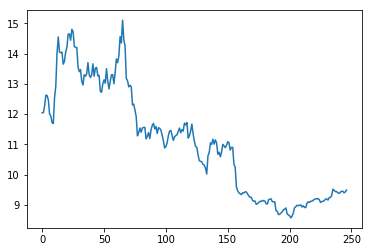

In [88]:
plt.plot(data)

结果为不平稳，一阶差分后平稳

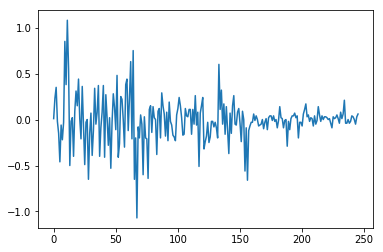

In [89]:
data = np.diff(data)
plt.plot(data)

单位根检验

In [90]:
t = sm.tsa.stattools.adfuller(data)  # ADF检验
print("p-value:   ",t[1])

p-value:    0.000162115148548


建立ARMA模型，先判定AR阶次，pacf

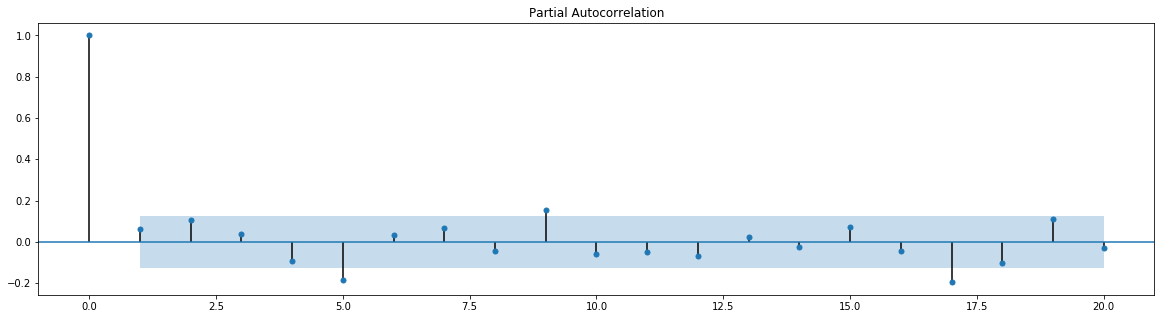

In [91]:
fig = plt.figure(figsize=(20,5))
ax1=fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(data,lags = 20,ax=ax1)

再判定MA的阶次，acf

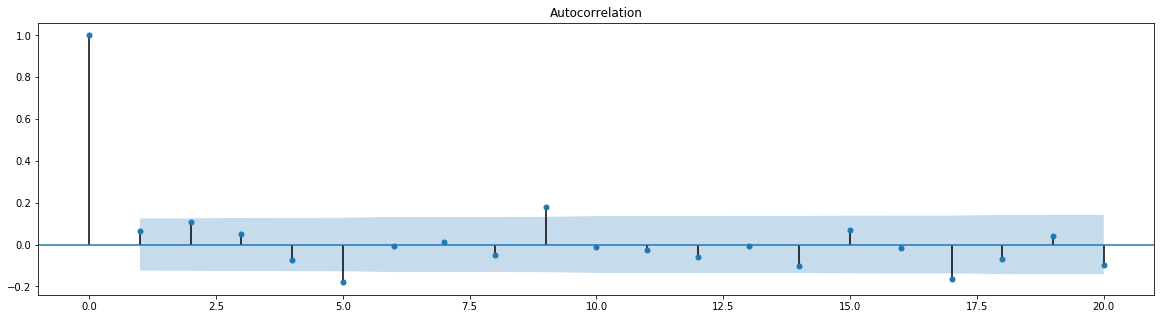

In [92]:
fig = plt.figure(figsize=(20,5))
ax1=fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(data,lags = 20,ax=ax1)

建立均值方程，ARMA(5,5)模型

In [93]:
order = (5,5)
model = sm.tsa.ARMA(data,order).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


计算残差及残差平方

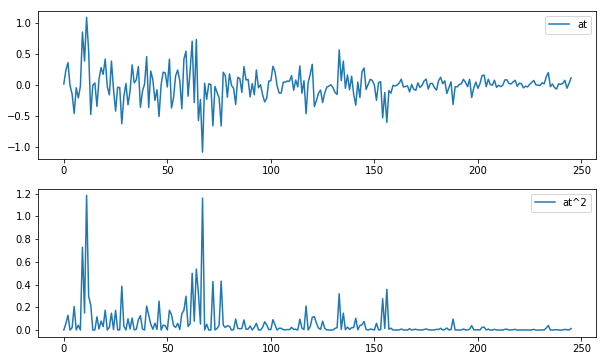

In [94]:
at = data -  model.fittedvalues
at2 = np.square(at)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(at,label = 'at')
plt.legend()
plt.subplot(212)
plt.plot(at2,label='at^2')
plt.legend(loc=0)

arch效应检验。对{at^2}序列进行混成检验： 原假设H0:序列没有相关性，备择假设H1：序列具有相关性

In [95]:
at = data -  model.fittedvalues
at2 = np.square(at)
m = 25 # 我们检验25个自相关系数
acf,q,p = sm.tsa.acf(at2,nlags=m,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,26), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,0.124498,3.859634,4.946111e-02
2.0,0.335687,32.034748,1.105969e-07
3.0,0.189016,41.004422,6.525095e-09
4.0,0.078291,42.549669,1.283132e-08
5.0,0.243627,57.574828,3.849279e-11
6.0,0.030056,57.804463,1.255403e-10
7.0,0.069098,59.023223,2.364503e-10
8.0,0.110400,62.147491,1.763732e-10
9.0,0.155230,68.350317,3.203881e-11


p-value小于显著性水平0.05，我们拒绝原假设，即认为序列具有相关性。因此具有ARCH效应。

实现GARCH(1,1)，利用极大似然估计拟合参数，进行预测

In [96]:
class Garch11(object):
    def __init__(self, series, at, alpha0 = 0.0001, alpha1 = 0.2, beta1 = 0.3):
        try:
            if alpha0 < 0 or alpha1 < 0 or beta1 < 0 or \
            alpha1 + beta1 >= 1:
                raise ValueError("Irregular coefficients")
            else:
                self.alpha0 = alpha0
                self.alpha1 = alpha1
                self.beta1 = beta1
        except ValueError:
            print("Initial condition leads to unstationary series or negative variance.")
            print("Resetting everything to default")
            self.alpha0 = 0.1
            self.alpha1 = 0.2
            self.beta1 = 0.3
        finally:
            self.mu = series.mean()#原始序列的均值
            self.sigma = at.std()#残差的方差
            self.size = len(series)
            self.data = series
    
    def params(self):#需要估计五个参数
        return [self.alpha0, self.alpha1, self.beta1, self.mu, self.sigma]
        
    @staticmethod
    def likelihood(param, data):#极大似然方程
        size = len(data)
        sq_resi_return = at ** 2#残差的平方
        variance = pd.Series(param[4] ** 2)#残差的方差
        #print(param[4] ** 2)
        variance = variance.append(param[0] + param[1] * sq_resi_return.shift(1).dropna())#Garch模型方程
        
        for idx in range(1, size):
            variance.iloc[idx] = variance.iloc[idx] + param[2] *\
            variance.iloc[idx - 1] #Garch模型方程
        
        likelihood = (size * np.log(2 * math.pi) + np.log(variance).sum()
        + (sq_resi_return / variance).sum()) / 2
        
        return likelihood
        
    def fit(self):  #拟合
        cons = ({'type' : 'ineq',
                 'fun' : lambda x : np.array([x[0] - 0.000001])},
                {'type' : 'ineq',
                 'fun' : lambda x : np.array([x[1] - 0.000001])},
                {'type' : 'ineq',
                 'fun' : lambda x : np.array([x[2] - 0.000001])},
                {'type' : 'ineq',
                 'fun' : lambda x : np.array([- x[1] - x[2] + 0.999999])},
                {'type' : 'ineq',
                 'fun' : lambda x : np.array([x[4] - 0.000001])}
                 )       
        res = sp.optimize.minimize(self.likelihood, np.array(self.params()),
                             args = (np.array(self.data)), constraints = cons,
                             method = 'COBYLA',
                             options = {'disp' : True})#最小化拟合的残差
        self.alpha0 = res.x[0]
        self.alpha1 = res.x[1]
        self.beta1 = res.x[2]
        self.mu = res.x[3]
        self.sigma = res.x[4]
        
    def predict(self, curr_var, sq_resid_return):#预测

        new_var = self.alpha0 + self.alpha1 * sq_resid_return + self.beta1 * curr_var
        
        return new_var

用Garch模型拟合上证50并预测

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log


parameters alpha0(omega), alpha1, beta1, mu, sigma are [8.9249618427667812e-05, 0.10366538720415636, 0.89521769231713966, -0.026774207457527167, 1.3357446967353048]


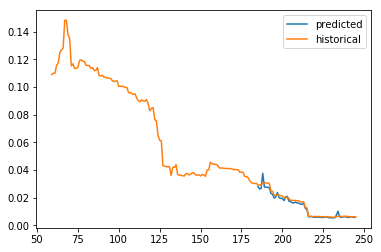

In [97]:
daily_return = pd.Series(data)
at = pd.Series(at)
variance = at.rolling(60).var()#残差的滚动方差，以60天为窗口
garch = Garch11(daily_return,at, 0.000006, 0.05, 0.9)
garch.fit()
print("parameters alpha0(omega), alpha1, beta1, mu, sigma are", garch.params())

sq_resid_re = at2#残差的平方
data = pd.DataFrame(data = [variance[-61:-1], sq_resid_re]).transpose()
data.columns = ['残差的方差', '残差的平方']
pred_var = data.apply(lambda x:garch.predict(x[0], x[1]), axis = 1)
pred = np.zeros(len(variance))
pred[-60:]=pred_var
hist_var = pd.Series(variance)
pred_var.plot()
hist_var.plot()
plt.legend(['predicted', 'historical'])